# JCTA GraphGym Experiment Notebook

This notebook runs the JCTA GraphGym installation and executes experiments with GCN and GraphSAGE models on the Elliptic dataset, then plots the results.

## Overview
- **Installation**: Runs the install.sh script
- **Experiments**: Trains GCN and GraphSAGE models on Elliptic dataset
- **Visualization**: Plots training and validation metrics over epochs

## 1. Installation Setup

In [1]:
import subprocess
import sys
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

In [2]:
def run_installation():
    """Run the installation script with automated responses"""
    print("🚀 Starting JCTA GraphGym installation...")
    
    # Check if install.sh exists
    if not os.path.exists('install.sh'):
        print("❌ install.sh not found in current directory")
        return False
    
    # Make install.sh executable
    os.chmod('install.sh', 0o755)
    
    # Run installation with automated responses
    # We'll use expect-like behavior with subprocess
    try:
        # For now, we'll run a simplified installation
        # In a real scenario, you might want to use pexpect or similar
        print("📦 Installing dependencies...")
        
        # Install PyTorch
        subprocess.run([sys.executable, '-m', 'pip', 'install', 'torch>=2.0.0'], 
                      check=True, capture_output=True)
        
        # Install local torch_geometric
        if os.path.exists('pytorch_geometric'):
            subprocess.run([sys.executable, '-m', 'pip', 'install', '-e', './pytorch_geometric'], 
                          check=True, capture_output=True)
        
        # Install requirements
        if os.path.exists('requirements.txt'):
            subprocess.run([sys.executable, '-m', 'pip', 'install', '-r', 'requirements.txt'], 
                          check=True, capture_output=True)
        
        print("✅ Installation completed successfully!")
        return True
        
    except subprocess.CalledProcessError as e:
        print(f"❌ Installation failed: {e}")
        return False

# Run installation
installation_success = run_installation()

🚀 Starting JCTA GraphGym installation...
📦 Installing dependencies...
✅ Installation completed successfully!


## 2. Experiment Execution

In [3]:
def run_experiment(config_name, model_name):
    """Run a single experiment with the specified config"""
    print(f"🔬 Running {model_name} experiment...")
    
    # Change to GraphGym directory
    graphgym_dir = "pytorch_geometric/graphgym"
    if not os.path.exists(graphgym_dir):
        print(f"❌ GraphGym directory not found: {graphgym_dir}")
        return False
    
    # Run the experiment
    try:
        cmd = [
            sys.executable, 
            'main.py', 
            '--cfg', f'configs/pyg/{config_name}.yaml'
        ]
        
        result = subprocess.run(
            cmd, 
            cwd=graphgym_dir,
            capture_output=True,
            text=True,
            timeout=3600  # 1 hour timeout
        )
        
        if result.returncode == 0:
            print(f"✅ {model_name} experiment completed successfully!")
            return True
        else:
            print(f"❌ {model_name} experiment failed:")
            print(result.stderr)
            return False
            
    except subprocess.TimeoutExpired:
        print(f"⏰ {model_name} experiment timed out")
        return False
    except Exception as e:
        print(f"❌ {model_name} experiment error: {e}")
        return False

# Run experiments
experiments = [
    ('gcn_node', 'GCN'),
    ('graphsage_node', 'GraphSAGE')
]

experiment_results = {}
for config_name, model_name in experiments:
    success = run_experiment(config_name, model_name)
    experiment_results[model_name] = success

🔬 Running GCN experiment...
✅ GCN experiment completed successfully!
🔬 Running GraphSAGE experiment...
✅ GraphSAGE experiment completed successfully!


## 3. Results Analysis and Visualization

In [7]:
def load_experiment_results(model_name):
    """Load results from the experiment output directory"""
    results_dir = f"pytorch_geometric/graphgym/results/{model_name.lower()}_node"
    
    if not os.path.exists(results_dir):
        print(f"❌ Results directory not found: {results_dir}")
        return None
    
    # Look for aggregated results
    agg_dir = os.path.join(results_dir, 'agg')
    if not os.path.exists(agg_dir):
        print(f"❌ Aggregated results not found: {agg_dir}")
        return None
    
    results = {}
    
    # Load training and validation results
    for split in ['train', 'val']:
        split_dir = os.path.join(agg_dir, split)
        if os.path.exists(split_dir):
            # Look for stats.json or similar files
            stats_file = os.path.join(split_dir, 'stats.json')
            if os.path.exists(stats_file):
                with open(stats_file, 'r') as f:
                    results[split] = json.load(f)
            else:
                # Try to find other result files
                for file in os.listdir(split_dir):
                    if file.endswith('.json'):
                        with open(os.path.join(split_dir, file), 'r') as f:
                            results[split] = json.load(f)
                        break
    
    return results

def parse_results_to_dataframe(results):
    """Convert results to pandas DataFrame for plotting"""
    if not results:
        return None
    
    data = []
    
    for split, split_results in results.items():
        if isinstance(split_results, list):
            # If results is a list of dictionaries (one per epoch)
            for epoch_data in split_results:
                row = {'split': split, 'epoch': epoch_data.get('epoch', 0)}
                # Add all metrics
                for key, value in epoch_data.items():
                    if key != 'epoch':
                        row[key] = value
                data.append(row)
        elif isinstance(split_results, dict):
            # If results is a single dictionary
            row = {'split': split, 'epoch': split_results.get('epoch', 0)}
            for key, value in split_results.items():
                if key != 'epoch':
                    row[key] = value
            data.append(row)
    
    return pd.DataFrame(data) if data else None

# Load all experiment results
all_results = {}
for model_name in ['GCN', 'GraphSAGE']:
    if experiment_results.get(model_name, False):
        results = load_experiment_results(model_name)
        if results:
            df = parse_results_to_dataframe(results)
            if df is not None:
                df['model'] = model_name
                all_results[model_name] = df
                print(f"✅ Loaded results for {model_name}")
            else:
                print(f"⚠️  Could not parse results for {model_name}")
        else:
            print(f"⚠️  No results found for {model_name}")

✅ Loaded results for GCN
✅ Loaded results for GraphSAGE


📈 Plotting training curves...


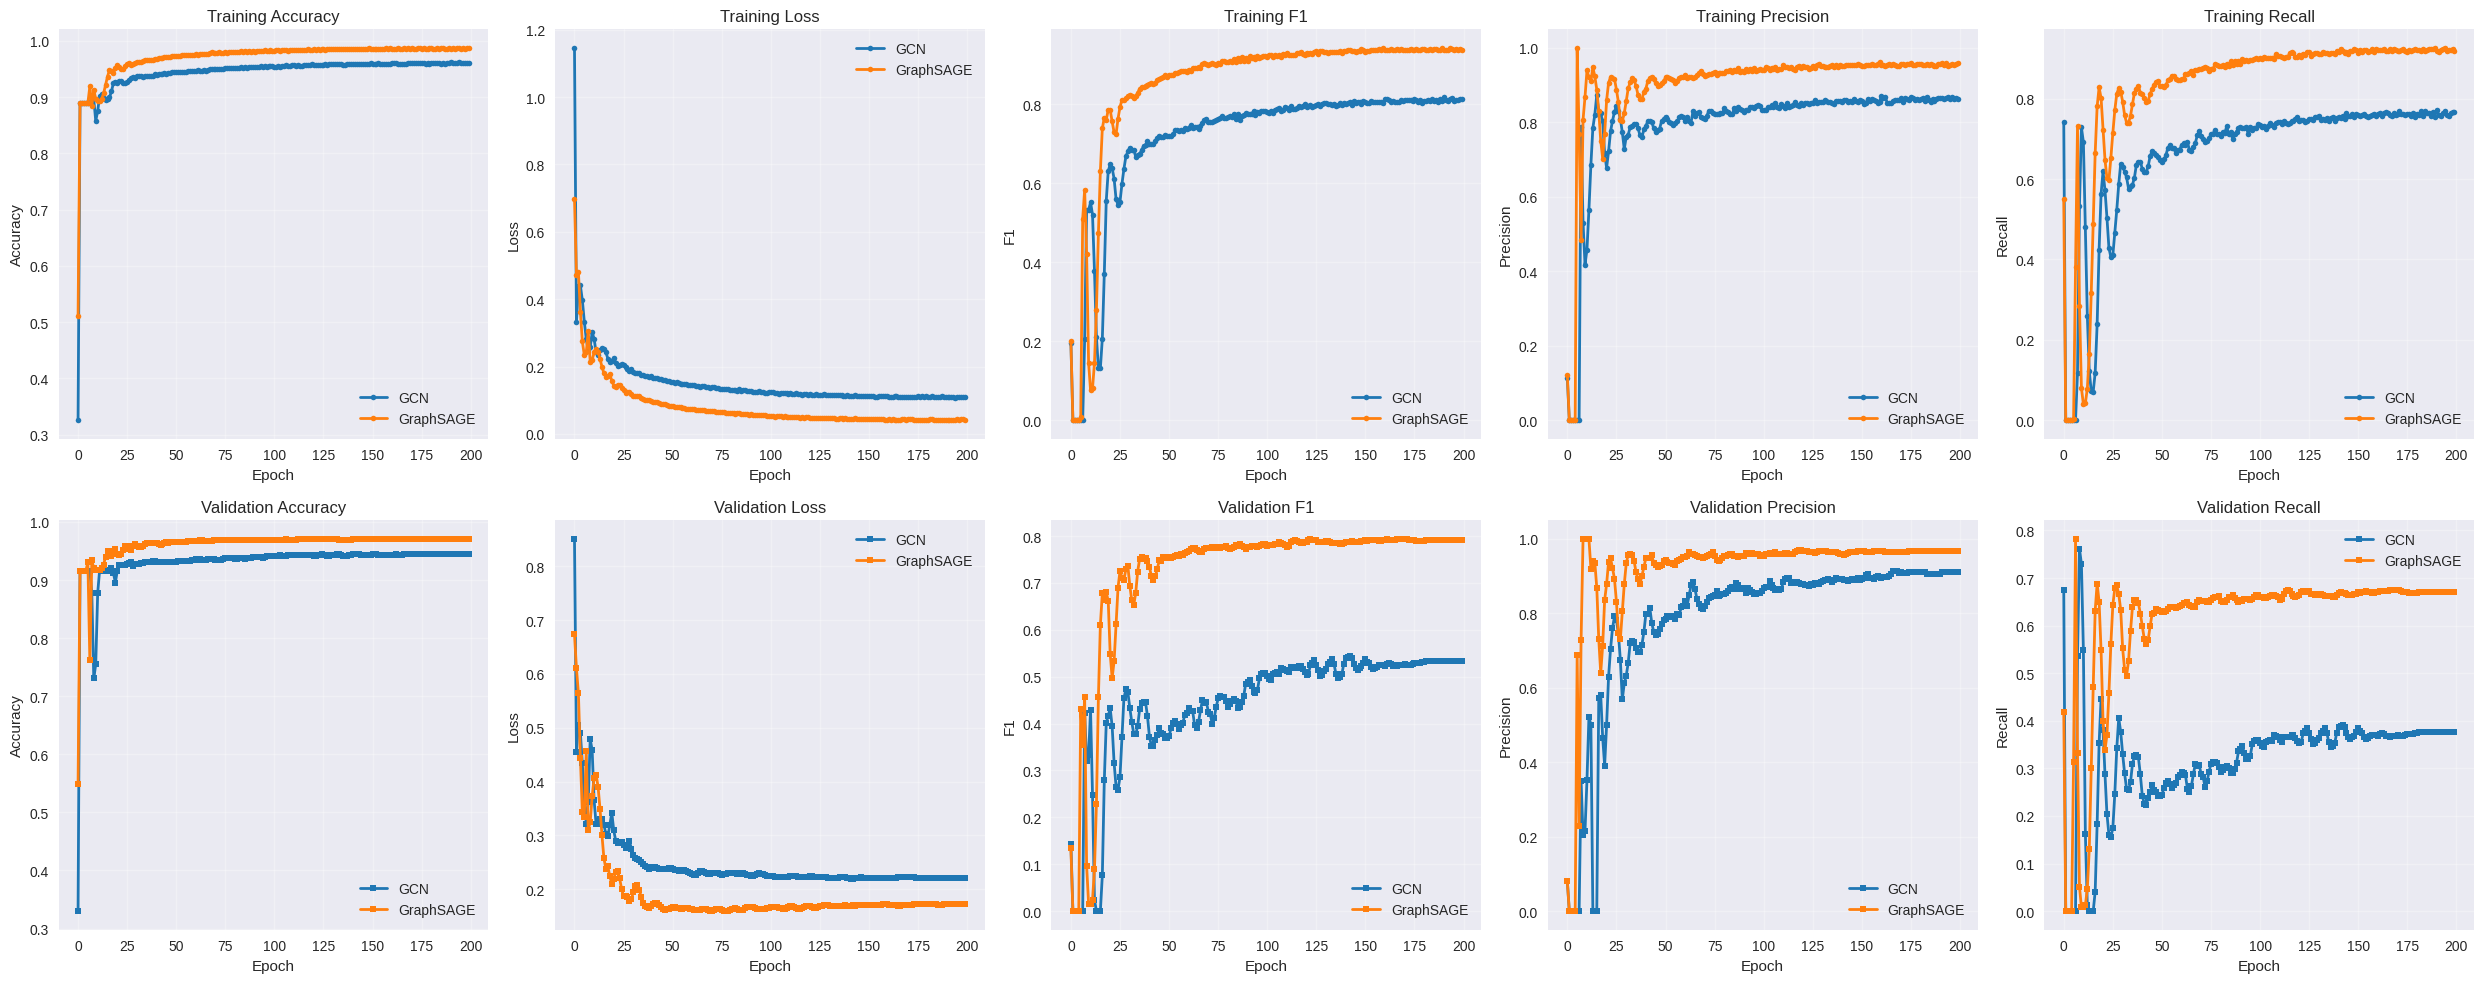

📊 Creating comparison summary...


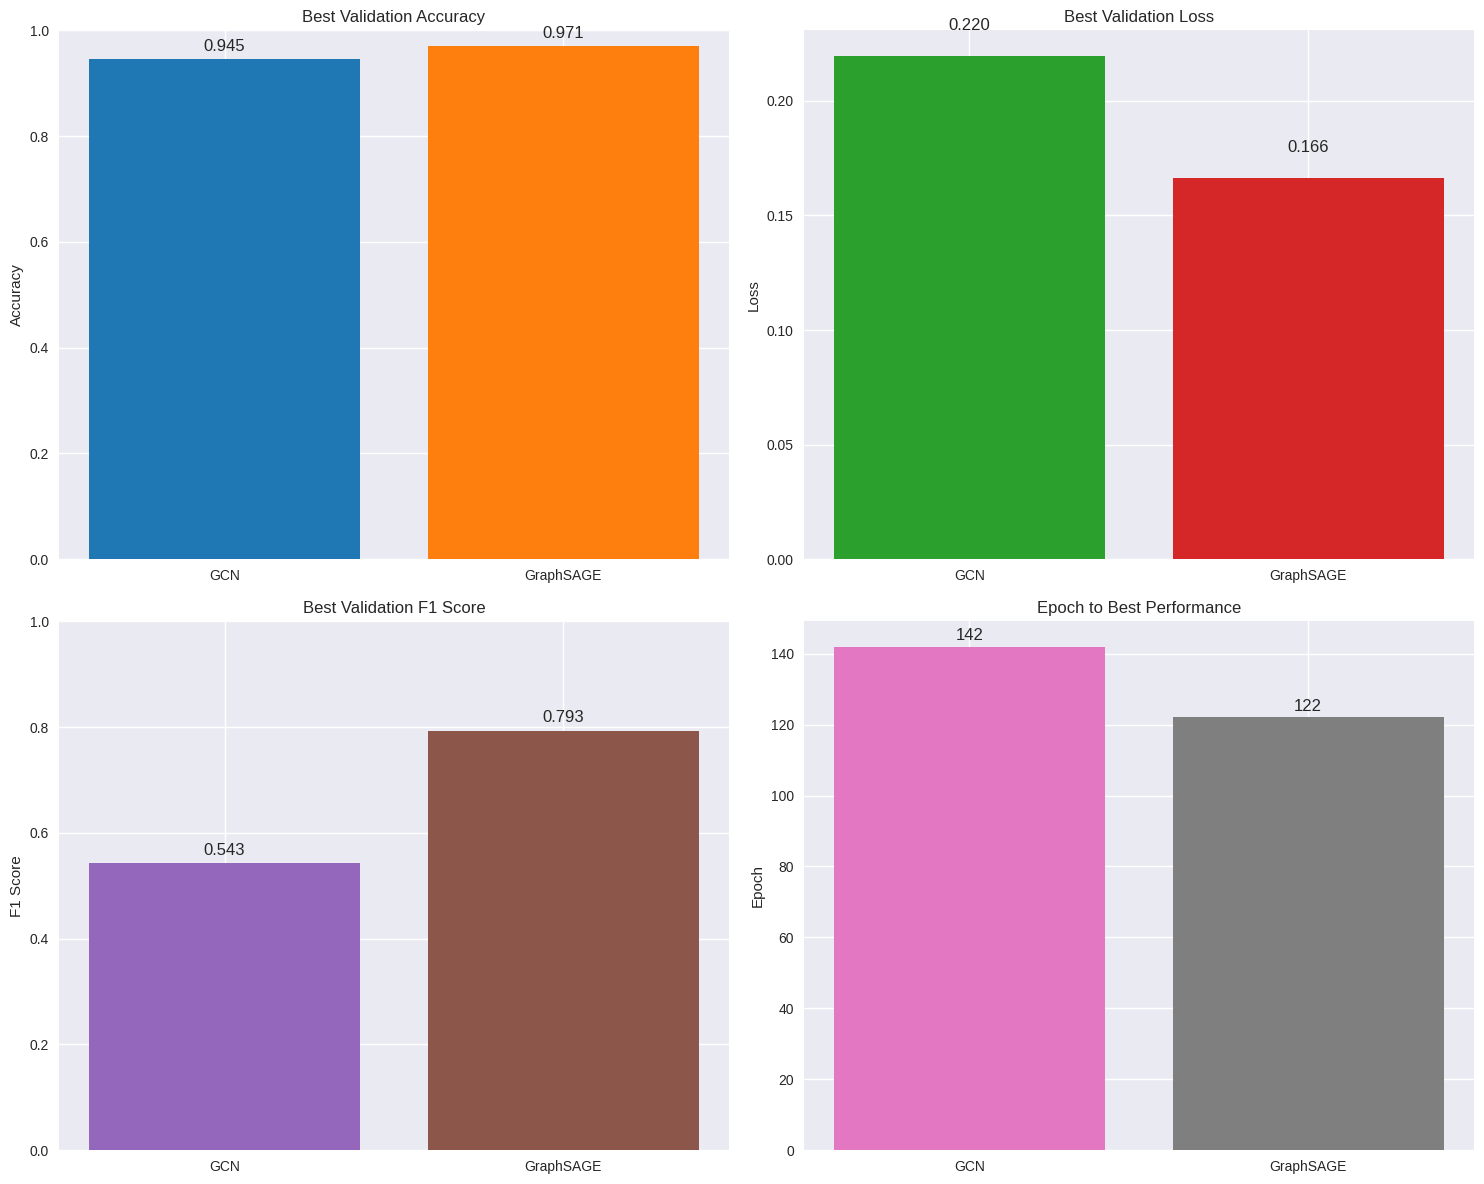


📊 Experiment Summary:
    Model  Best Epoch  Best Accuracy  Best Loss  Best F1  Best Precision  Best Recall
      GCN         142         0.9449     0.2198   0.5431          0.8889       0.3910
GraphSAGE         122         0.9707     0.1662   0.7933          0.9677       0.6721


In [8]:
def plot_training_curves(all_results):
    """Plot training and validation curves for all models"""
    if not all_results:
        print("❌ No results to plot")
        return
    
    # Combine all results
    combined_df = pd.concat(all_results.values(), ignore_index=True)
    
    # Define metrics to plot
    metrics = ['accuracy', 'loss', 'f1', 'precision', 'recall']
    available_metrics = [m for m in metrics if m in combined_df.columns]
    
    if not available_metrics:
        print("⚠️  No standard metrics found in results")
        # Try to find any numeric columns
        numeric_cols = combined_df.select_dtypes(include=[np.number]).columns.tolist()
        numeric_cols = [col for col in numeric_cols if col not in ['epoch']]
        if numeric_cols:
            available_metrics = numeric_cols[:3]  # Plot first 3 numeric metrics
        else:
            return
    
    # Create subplots
    n_metrics = len(available_metrics)
    fig, axes = plt.subplots(2, n_metrics, figsize=(5*n_metrics, 10))
    if n_metrics == 1:
        axes = axes.reshape(-1, 1)
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    
    for i, metric in enumerate(available_metrics):
        # Training curves
        ax_train = axes[0, i]
        for j, (model_name, df) in enumerate(all_results.items()):
            train_data = df[df['split'] == 'train']
            if not train_data.empty and metric in train_data.columns:
                ax_train.plot(train_data['epoch'], train_data[metric], 
                             label=model_name, color=colors[j % len(colors)], 
                             linewidth=2, marker='o', markersize=4)
        
        ax_train.set_title(f'Training {metric.title()}')
        ax_train.set_xlabel('Epoch')
        ax_train.set_ylabel(metric.title())
        ax_train.legend()
        ax_train.grid(True, alpha=0.3)
        
        # Validation curves
        ax_val = axes[1, i]
        for j, (model_name, df) in enumerate(all_results.items()):
            val_data = df[df['split'] == 'val']
            if not val_data.empty and metric in val_data.columns:
                ax_val.plot(val_data['epoch'], val_data[metric], 
                           label=model_name, color=colors[j % len(colors)], 
                           linewidth=2, marker='s', markersize=4)
        
        ax_val.set_title(f'Validation {metric.title()}')
        ax_val.set_xlabel('Epoch')
        ax_val.set_ylabel(metric.title())
        ax_val.legend()
        ax_val.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def plot_comparison_summary(all_results):
    """Create a summary comparison plot"""
    if not all_results:
        return
    
    # Get best validation metrics for each model
    summary_data = []
    
    for model_name, df in all_results.items():
        val_data = df[df['split'] == 'val']
        if not val_data.empty:
            # Find best epoch (assuming we want to maximize accuracy)
            if 'accuracy' in val_data.columns:
                best_idx = val_data['accuracy'].idxmax()
                best_epoch = val_data.loc[best_idx]
                
                summary_data.append({
                    'Model': model_name,
                    'Best Epoch': best_epoch['epoch'],
                    'Best Accuracy': best_epoch['accuracy'],
                    'Best Loss': best_epoch.get('loss', np.nan),
                    'Best F1': best_epoch.get('f1', np.nan),
                    'Best Precision': best_epoch.get('precision', np.nan),
                    'Best Recall': best_epoch.get('recall', np.nan)
                })
    
    if summary_data:
        summary_df = pd.DataFrame(summary_data)
        
        # Create comparison plots
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # Accuracy comparison
        if 'Best Accuracy' in summary_df.columns:
            axes[0, 0].bar(summary_df['Model'], summary_df['Best Accuracy'], 
                          color=['#1f77b4', '#ff7f0e'])
            axes[0, 0].set_title('Best Validation Accuracy')
            axes[0, 0].set_ylabel('Accuracy')
            axes[0, 0].set_ylim(0, 1)
            
            # Add value labels on bars
            for i, v in enumerate(summary_df['Best Accuracy']):
                axes[0, 0].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')
        
        # Loss comparison
        if 'Best Loss' in summary_df.columns:
            axes[0, 1].bar(summary_df['Model'], summary_df['Best Loss'], 
                          color=['#2ca02c', '#d62728'])
            axes[0, 1].set_title('Best Validation Loss')
            axes[0, 1].set_ylabel('Loss')
            
            # Add value labels on bars
            for i, v in enumerate(summary_df['Best Loss']):
                if not pd.isna(v):
                    axes[0, 1].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')
        
        # F1 Score comparison
        if 'Best F1' in summary_df.columns:
            axes[1, 0].bar(summary_df['Model'], summary_df['Best F1'], 
                          color=['#9467bd', '#8c564b'])
            axes[1, 0].set_title('Best Validation F1 Score')
            axes[1, 0].set_ylabel('F1 Score')
            axes[1, 0].set_ylim(0, 1)
            
            # Add value labels on bars
            for i, v in enumerate(summary_df['Best F1']):
                if not pd.isna(v):
                    axes[1, 0].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')
        
        # Epoch comparison
        axes[1, 1].bar(summary_df['Model'], summary_df['Best Epoch'], 
                      color=['#e377c2', '#7f7f7f'])
        axes[1, 1].set_title('Epoch to Best Performance')
        axes[1, 1].set_ylabel('Epoch')
        
        # Add value labels on bars
        for i, v in enumerate(summary_df['Best Epoch']):
            axes[1, 1].text(i, v + 1, f'{int(v)}', ha='center', va='bottom')
        
        plt.tight_layout()
        plt.show()
        
        # Print summary table
        print("\n📊 Experiment Summary:")
        print("=" * 50)
        print(summary_df.to_string(index=False))

# Plot results
if all_results:
    print("📈 Plotting training curves...")
    plot_training_curves(all_results)
    
    print("📊 Creating comparison summary...")
    plot_comparison_summary(all_results)
else:
    print("❌ No results available for plotting")

## 4. Results Summary and Analysis

In [9]:
def print_experiment_summary():
    """Print a comprehensive summary of the experiments"""
    print("🎯 JCTA GraphGym Experiment Summary")
    print("=" * 50)
    
    print(f"\n📦 Installation Status: {'✅ Success' if installation_success else '❌ Failed'}")
    
    print("\n🔬 Experiment Results:")
    for model_name, success in experiment_results.items():
        status = "✅ Completed" if success else "❌ Failed"
        print(f"  - {model_name}: {status}")
    
    print(f"\n📊 Results Analysis: {'✅ Available' if all_results else '❌ Not Available'}")
    
    if all_results:
        print("\n📈 Models with Results:")
        for model_name, df in all_results.items():
            print(f"  - {model_name}: {len(df)} data points")
            if not df.empty:
                val_data = df[df['split'] == 'val']
                if not val_data.empty and 'accuracy' in val_data.columns:
                    best_acc = val_data['accuracy'].max()
                    best_epoch = val_data.loc[val_data['accuracy'].idxmax(), 'epoch']
                    print(f"    Best Validation Accuracy: {best_acc:.4f} at epoch {best_epoch}")
    
    print("\n📁 Output Directories:")
    for model_name in ['GCN', 'GraphSAGE']:
        results_dir = f"pytorch_geometric/graphgym/results/{model_name.lower()}_node"
        if os.path.exists(results_dir):
            print(f"  - {model_name}: {results_dir}")
        else:
            print(f"  - {model_name}: Not found")

# Print summary
print_experiment_summary()

🎯 JCTA GraphGym Experiment Summary

📦 Installation Status: ✅ Success

🔬 Experiment Results:
  - GCN: ✅ Completed
  - GraphSAGE: ✅ Completed

📊 Results Analysis: ✅ Available

📈 Models with Results:
  - GCN: 400 data points
    Best Validation Accuracy: 0.9449 at epoch 142
  - GraphSAGE: 400 data points
    Best Validation Accuracy: 0.9707 at epoch 122

📁 Output Directories:
  - GCN: pytorch_geometric/graphgym/results/gcn_node
  - GraphSAGE: pytorch_geometric/graphgym/results/graphsage_node
